In [1]:
import pandas as pd
import numpy as np
import data_preprocess as dp
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('./data/D2.csv')

In [3]:
df = dp.data_prep(data)

In [4]:
# drop the rows with where discharge_disposition is deceased
df = df[df.discharge_disposition != 'Deceased']

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19680 entries, 0 to 19999
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   race                   19680 non-null  object
 1   gender                 19680 non-null  int64 
 2   age                    19680 non-null  int64 
 3   time_in_hospital       19680 non-null  int64 
 4   medical_specialty      19680 non-null  object
 5   num_lab_procedures     19680 non-null  int64 
 6   num_procedures         19680 non-null  int64 
 7   num_medications        19680 non-null  int64 
 8   number_outpatient      19680 non-null  int64 
 9   number_emergency       19680 non-null  int64 
 10  number_inpatient       19680 non-null  int64 
 11  number_diagnoses       19680 non-null  int64 
 12  metformin              19680 non-null  int64 
 13  repaglinide            19680 non-null  int64 
 14  nateglinide            19680 non-null  int64 
 15  chlorpropamide         1

In [6]:
# Step 1: Separating the features and target variable
X = df.drop('readmitted', axis=1)  # Features
y = df['readmitted']  # Target

In [7]:
# Identifying categorical columns that need encoding
categorical_columns = ['race', 'medical_specialty', 'admission_type', 'discharge_disposition', 'admission_source']
numerical_columns = ['gender', 'age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications',
                     'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 
                     'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 
                     'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'insulin', 'change', 'diabetesMed']

In [8]:
label_encoder = LabelEncoder()
X['age'] = label_encoder.fit_transform(X['age'])

In [9]:
X = pd.get_dummies(X, columns=categorical_columns, dtype=int)

In [10]:
X.head(10)

,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,...,admission_type_Elective,admission_type_Emergency,admission_type_Unknown,discharge_disposition_AdditonalCare,discharge_disposition_Home,discharge_disposition_Unknown,admission_source_Emergency,admission_source_Referral,admission_source_Transfer,admission_source_Unknown
0,1,8,1,33,0,14,0,1,1,9,...,0,1,0,1,0,0,1,0,0,0
1,1,7,3,48,2,7,0,0,2,9,...,0,1,0,1,0,0,0,0,1,0
2,1,5,3,25,1,15,0,0,0,8,...,1,0,0,0,1,0,0,1,0,0
3,1,5,6,41,0,19,0,0,0,9,...,0,1,0,0,1,0,1,0,0,0
4,0,8,4,22,0,12,0,0,1,8,...,0,1,0,1,0,0,1,0,0,0
5,1,4,4,10,0,31,1,0,0,9,...,1,0,0,1,0,0,0,0,1,0
6,0,8,4,56,2,14,0,0,1,9,...,0,1,0,1,0,0,1,0,0,0
7,1,6,3,51,0,11,0,0,0,8,...,1,0,0,0,1,0,0,1,0,0
8,0,4,1,1,1,4,0,0,0,4,...,0,1,0,1,0,0,0,1,0,0
9,0,6,1,46,6,9,0,0,0,9,...,0,0,1,0,1,0,0,0,0,1


In [11]:
scaler = StandardScaler()
X[numerical_columns] = scaler.fit_transform(X[numerical_columns])


In [12]:
from sklearn.model_selection import train_test_split

In [53]:
X_mat =X.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X_mat, y, test_size=0.25, stratify=y, random_state=0)

In [54]:
# Importing the model
from sklearn.linear_model import LogisticRegression


In [56]:
# Instantiating the model

model = LogisticRegression(random_state=0 )
model.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [57]:
from sklearn.metrics import classification_report

# training and test accuracy
print("Train accuracy:", model.score(X_train, y_train))
print("Test accuracy:", model.score(X_test, y_test))

# classification report on test data
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

Train accuracy: 0.6313008130081301
Test accuracy: 0.6280487804878049
              precision    recall  f1-score   support

           0       0.62      0.78      0.69      2589
           1       0.65      0.46      0.54      2331

    accuracy                           0.63      4920
   macro avg       0.63      0.62      0.61      4920
weighted avg       0.63      0.63      0.62      4920



In [58]:
# Getting the coefficients for all features
coefficients = model.coef_[0]

In [59]:
coefficients

array([ 1.14359088e-02,  9.96778355e-02, -1.85396333e-02,  4.42686465e-02,
       -1.98768874e-02,  8.74835683e-02,  1.04325925e-01,  2.57477909e-01,
        6.14305197e-01,  7.20203627e-02, -5.26172911e-02,  2.69370903e-04,
       -1.19043781e-02,  1.18782962e-01,  8.61327752e-04,  0.00000000e+00,
        1.60124963e-02,  1.53094847e-02,  0.00000000e+00,  3.52603207e-02,
        3.90796399e-03,  1.04256987e-01,  4.08137070e-03, -1.93691185e-02,
        1.87796712e-01, -2.53384054e-01, -1.14771349e-01,  4.85611854e-02,
        1.15769545e-01, -2.62590934e-01,  8.64690148e-02, -1.83855250e-01,
       -2.06418132e-01, -7.66748822e-02,  8.74465748e-02, -1.47801442e-01,
       -8.84203173e-02,  4.05753196e-02,  1.96149503e-01,  1.88912251e-01,
       -4.28901188e-01, -1.51807006e-01])

In [60]:
# grab feature importances from the model and feature name from the original X
coef = model.coef_[0]
feature_names = X.columns

# sort them out in descending order
indices = np.argsort(np.absolute(coef))
indices = np.flip(indices, axis=0)

# limit to 20 features, you can leave this out to print out everything
indices = indices[:20]

for i in indices:
    print(f"{feature_names[i]} -> {coef[i]:.3f}")

number_inpatient -> 0.614
admission_source_Transfer -> -0.429
medical_specialty_Internal Medicine -> -0.263
number_emergency -> 0.257
race_Hispanic -> -0.253
admission_type_Elective -> -0.206
admission_source_Emergency -> 0.196
admission_source_Referral -> 0.189
race_Caucasian -> 0.188
medical_specialty_Surgical -> -0.184
admission_source_Unknown -> -0.152
discharge_disposition_AdditonalCare -> -0.148
chlorpropamide -> 0.119
medical_specialty_General Practice -> 0.116
race_Other -> -0.115
number_outpatient -> 0.104
diabetesMed -> 0.104
age -> 0.100
discharge_disposition_Home -> -0.088
num_medications -> 0.087


In [61]:
# perform cross validation with gridsearchCV
from sklearn.model_selection import GridSearchCV


In [62]:
# defining the hyperparameters
params = {
    'C': [pow(10, x) for x in range(-6, 4)]
}

In [63]:
# Instantiating the gridsearch
grid_search = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=42),return_train_score=True, cv=10, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


GridSearchCV(cv=10, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10,
                               100, 1000]},
             return_train_score=True, verbose=1)

In [64]:
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best accuracy score: {grid_search.best_score_}")

Best parameters found: {'C': 0.01}
Best accuracy score: 0.6289972899728997


In [65]:
results = pd.DataFrame(grid_search.cv_results_)

In [66]:
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.052331,0.011135,0.001852,0.000317,0.000001,{'C': 1e-06},0.526423,0.526423,0.526423,0.526423,...,0.526272,0.526272,0.526272,0.526272,0.526272,0.526272,0.526347,0.526347,0.526287,0.000030
1,0.062854,0.032073,0.002966,0.002310,0.000010,{'C': 1e-05},0.534553,0.533198,0.532520,0.533875,...,0.532445,0.532520,0.532671,0.533047,0.532746,0.532671,0.532520,0.532445,0.532550,0.000257
2,0.041402,0.006469,0.002007,0.000594,0.000100,{'C': 0.0001},0.608401,0.621951,0.608401,0.617209,...,0.607272,0.606218,0.608928,0.607197,0.607949,0.608702,0.608326,0.606820,0.607468,0.001177
3,0.065223,0.006634,0.003409,0.003887,0.001000,{'C': 0.001},0.627371,0.637534,0.626694,0.634824,...,0.626092,0.626543,0.628275,0.628124,0.628651,0.627823,0.628425,0.623532,0.627040,0.001491
4,0.149143,0.028758,0.002141,0.000331,0.010000,{'C': 0.01},0.640244,0.643631,0.640244,0.628049,...,0.630307,0.631512,0.634297,0.631888,0.633394,0.632716,0.632716,0.628425,0.631564,0.001700
5,0.148226,0.020460,0.002384,0.000434,0.100000,{'C': 0.1},0.640921,0.642954,0.638889,0.625339,...,0.630081,0.632490,0.634297,0.633092,0.633619,0.634146,0.633318,0.629103,0.632264,0.001731
6,0.166356,0.034507,0.002623,0.000503,1.000000,{'C': 1},0.641599,0.644309,0.636856,0.624661,...,0.630759,0.632189,0.633544,0.633168,0.633318,0.634222,0.632867,0.629178,0.632106,0.001620
7,0.167641,0.035455,0.002848,0.000906,10.000000,{'C': 10},0.642276,0.644309,0.636856,0.624661,...,0.630608,0.632189,0.633695,0.633092,0.633243,0.634146,0.632791,0.629103,0.632069,0.001719
8,0.172391,0.034903,0.002461,0.000585,100.000000,{'C': 100},0.642276,0.644309,0.636856,0.624661,...,0.630533,0.632189,0.633695,0.633092,0.633394,0.633921,0.632867,0.628802,0.632016,0.001763
9,0.135501,0.022960,0.001804,0.000644,1000.000000,{'C': 1000},0.642276,0.644309,0.636856,0.624661,...,0.630533,0.632189,0.633695,0.633092,0.633394,0.633921,0.632867,0.628877,0.632008,0.001745


In [67]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.78      0.69      2589
           1       0.65      0.46      0.54      2331

    accuracy                           0.63      4920
   macro avg       0.63      0.62      0.61      4920
weighted avg       0.63      0.63      0.62      4920



In [68]:
mean_train_scores = results['mean_train_score']
mean_test_scores = results['mean_test_score']


TypeError: object of type 'int' has no len()

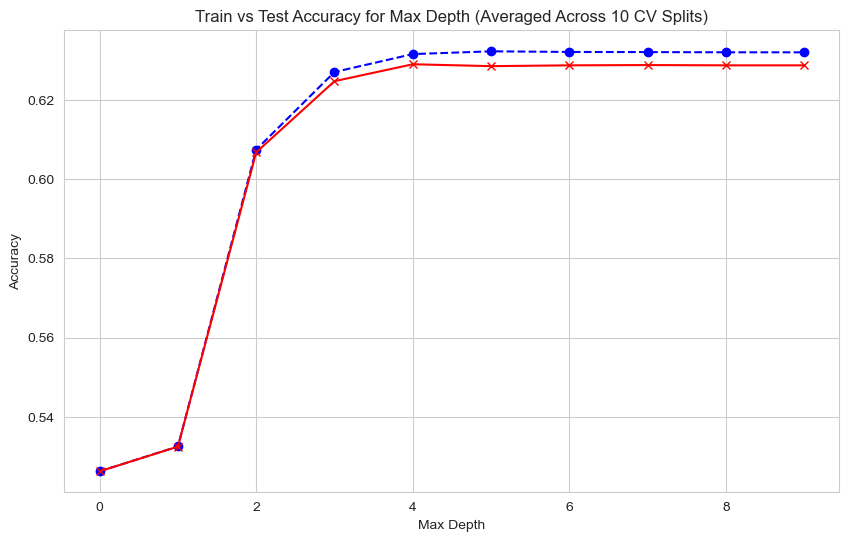

In [70]:
# Plot the results for max_depth
plt.figure(figsize=(10, 6))
plt.plot(mean_train_scores.index, mean_train_scores, label='Mean Train Score', marker='o', linestyle='--', color='b')
plt.plot(mean_test_scores.index, mean_test_scores, label='Mean Test Score', marker='x', linestyle='-', color='r')

# Add labels and title
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy for Max Depth (Averaged Across 10 CV Splits)')
plt.xticks(range(0, len(len(results))),[pow(10, x) for x in range(-6, 4)])
plt.legend()
plt.grid(True)
plt.show()

In [71]:
grid_search.best_params_

{'C': 0.01}

In [73]:
# Using the best hyperparameters
best_model = LogisticRegression(C=0.01, random_state=42)
best_model.fit(X_train, y_train)

LogisticRegression(C=0.01, random_state=42)

In [74]:
# training and test accuracy
print("Train accuracy:", best_model.score(X_train, y_train))
print("Test accuracy:", best_model.score(X_test, y_test))


Train accuracy: 0.6317073170731707
Test accuracy: 0.626219512195122


In [33]:
from sklearn.feature_selection import RFECV

In [75]:
rfe = RFECV(estimator=LogisticRegression(C=0.01, random_state=42), cv=10)
rfe.fit(X_train, y_train)

RFECV(cv=10, estimator=LogisticRegression(C=0.01, random_state=42))

In [76]:
print(f"Original feature set: {X_train.shape[1]}")
print(f"Optimal number of features : {rfe.n_features_}")

Original feature set: 42
Optimal number of features : 13


In [77]:
X_train_sel = rfe.transform(X_train)
X_test_sel = rfe.transform(X_test)

In [78]:
params

{'C': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}

In [80]:
rfe_grid_search = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=0),return_train_score=True, cv=10, n_jobs=-1, verbose=1)

In [81]:
rfe_grid_search.fit(X_train_sel, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


GridSearchCV(cv=10, estimator=LogisticRegression(random_state=0), n_jobs=-1,
             param_grid={'C': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10,
                               100, 1000]},
             return_train_score=True, verbose=1)

In [82]:
print(f"Best parameters found: {rfe_grid_search.best_params_}")
print(f"Best accuracy score: {rfe_grid_search.best_score_}")
print(f"Train score: {rfe_grid_search.score(X_train_sel, y_train)}")
print(f"Test score: {rfe_grid_search.score(X_test_sel, y_test)}")



Best parameters found: {'C': 0.1}
Best accuracy score: 0.6296747967479674
Train score: 0.6304878048780488
Test score: 0.6260162601626016


In [83]:
y_pred = rfe_grid_search.predict(X_test_sel)

In [84]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.79      0.69      2589
           1       0.65      0.45      0.53      2331

    accuracy                           0.63      4920
   macro avg       0.63      0.62      0.61      4920
weighted avg       0.63      0.63      0.61      4920



In [85]:
coefs = model.coef_[0]
selected_coefs = coefs[rfe.support_]
feature_names = X.columns[rfe.support_]

# sort them out in descending order
indices = np.argsort(np.absolute(selected_coefs))
indices = np.flip(indices, axis=0)


for i in indices:
    print(f"{feature_names[i]} -> {selected_coefs[i]:.3f}")

number_inpatient -> 0.614
admission_source_Transfer -> -0.429
medical_specialty_Internal Medicine -> -0.263
number_emergency -> 0.257
admission_type_Elective -> -0.206
admission_source_Emergency -> 0.196
admission_source_Referral -> 0.189
race_Caucasian -> 0.188
medical_specialty_Surgical -> -0.184
number_outpatient -> 0.104
diabetesMed -> 0.104
age -> 0.100
num_medications -> 0.087
